In [1]:
import asteroid
asteroid.__version__

'0.3.3'

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import librosa

import torch
import torch.nn as nn
import torch.functional as F

# Asteroid Notebooks: 01 Getting Started

In [3]:
from asteroid.filterbanks import STFTFB, Encoder, Decoder

fb = STFTFB(n_filters=256, kernel_size=128, stride=64)
encoder = Encoder(fb)

decoder_fb = STFTFB(n_filters=256, kernel_size=128, stride=64)
decoder = Decoder(decoder_fb)

In [4]:
wav = torch.randn(2, 1, 16000)
tf_rep = encoder(wav)
wav_back = decoder(tf_rep)

In [5]:
chirp = torch.Tensor(librosa.chirp(440, 640, sr=22050, duration=1).reshape(1,1,-1))
tf_chirp = encoder(chirp)
chirp_back = decoder(tf_chirp)

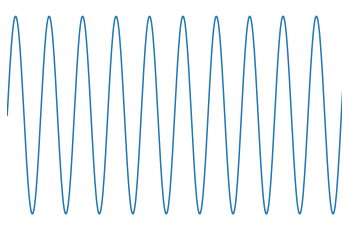

In [6]:
plt.plot(np.squeeze(chirp.numpy()))
plt.xlim([0, 500])
plt.axis('off')
plt.show()

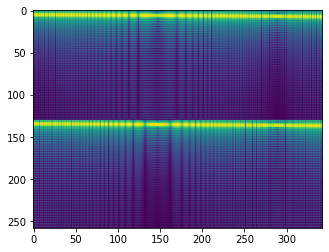

In [7]:
plt.imshow(np.log10(np.abs(tf_chirp[0].numpy()) + 1e-4))

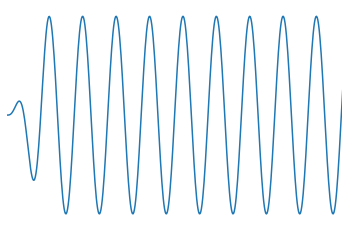

In [8]:
plt.plot(np.squeeze(chirp_back.numpy()))
plt.xlim([0, 500])
plt.axis('off')
plt.show()

In [9]:
from asteroid.masknn import TDConvNet
masker = TDConvNet(in_chan=128, n_src=2)
tf_rep = torch.randn(2, 128, 10)
wav_back = masker(tf_rep)

In [10]:
from asteroid.filterbanks import make_enc_dec

class Model(torch.nn.Module):
    def __init__(self):
        super().__init__()

        self.enc, self.dec = make_enc_dec('stft', 
                                          n_filters=256, 
                                          kernel_size=128, 
                                          stride=64)
        
        self.masker = TDConvNet(in_chan=self.enc.n_feats_out, 
                                n_src=2)
    
    def forward(self, wav):
        tf_rep = self.enc(wav)
        masks = self.masker(tf_rep)
        wavs_out = self.dec(tf_rep.unsqueeze(1) * masks)
        return wavs_out

stft_conv_tasnet = Model()
wav_out = stft_conv_tasnet(torch.randn(1, 1, 16000))

In [11]:
from asteroid import ConvTasNet
model = ConvTasNet(n_src=2)

In [12]:
from asteroid.data import LibriMix

train_set, val_set = LibriMix.mini_from_download(task='sep_clean')

Drop 0 utterances from 800 (shorter than 3 seconds)
Drop 0 utterances from 200 (shorter than 3 seconds)


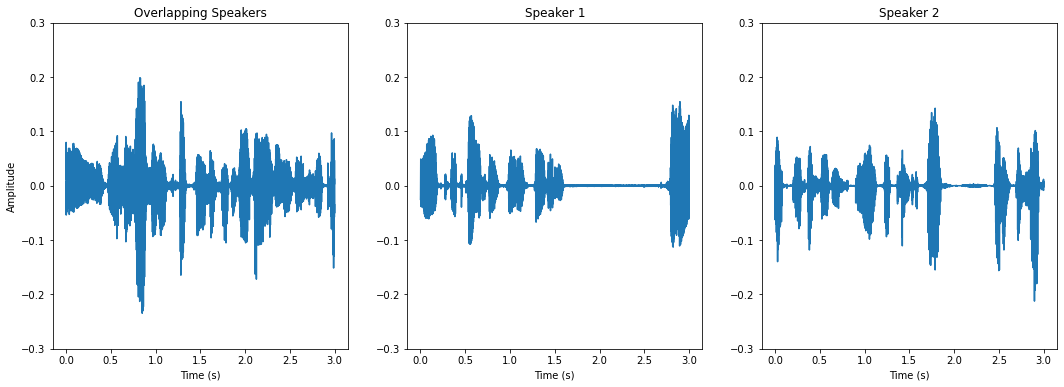

In [13]:
SR = 8000
ts = np.arange(len(train_set[0][0])) / SR
fig, _ = plt.subplots(1,3, figsize=(18,6), sharey=True)
plt.subplot(1,3,1)
plt.plot(ts, train_set[0][0].numpy())
plt.ylim([-0.3, 0.3])
plt.title('Overlapping Speakers')
plt.ylabel('Amplitude')
plt.xlabel('Time (s)')
plt.subplot(1,3,2)
plt.plot(ts, train_set[0][1][0].numpy())
plt.ylim([-0.3, 0.3])
plt.title('Speaker 1')
plt.xlabel('Time (s)')
plt.subplot(1,3,3)
plt.plot(ts, train_set[0][1][1].numpy())
plt.ylim([-0.3, 0.3])
plt.title('Speaker 2')
plt.xlabel('Time (s)')
plt.show()

In [14]:
from IPython.display import Audio

Audio(train_set[0][0], rate=SR)

In [15]:
Audio(train_set[0][1][0], rate=SR)

In [16]:
Audio(train_set[0][1][1], rate=SR)

In [17]:
from asteroid.losses import PITLossWrapper, pairwise_neg_sisdr
loss_func = PITLossWrapper(pairwise_neg_sisdr, pit_from='pw_mtx')

In [18]:
from torch.optim import Adam
from torch.utils.data import DataLoader
import pytorch_lightning as pl

from asteroid.data import LibriMix
from asteroid.engine.system import System
from asteroid.losses import PITLossWrapper, pairwise_neg_sisdr
from asteroid import ConvTasNet

train_set, val_set = LibriMix.mini_from_download(task='sep_clean')
train_loader = DataLoader(train_set, batch_size=4, drop_last=True)
val_loader = DataLoader(val_set, batch_size=4, drop_last=True)

model = ConvTasNet(n_src=2, n_repeats=1)
optimizer = Adam(model.parameters(), lr=1e-3)
loss_func = PITLossWrapper(pairwise_neg_sisdr, pit_from='pw_mtx')

system = System(model=model, loss_func=loss_func, optimizer=optimizer,
                train_loader=train_loader, val_loader=val_loader)

trainer = pl.Trainer(fast_dev_run=True)
trainer.fit(system)

Running in fast_dev_run mode: will run a full train, val and test loop using a single batch


Drop 0 utterances from 800 (shorter than 3 seconds)
Drop 0 utterances from 200 (shorter than 3 seconds)


GPU available: True, used: False
TPU available: False, using: 0 TPU cores
/opt/conda/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:37: UserWarning: GPU available but not used. Set the --gpus flag when calling the script.
  warnings.warn(*args, **kwargs)
/opt/conda/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:37: UserWarning: Could not log computational graph since the `model.example_input_array` attribute is not set or `input_array` was not given
  warnings.warn(*args, **kwargs)

  | Name      | Type           | Params
---------------------------------------------
0 | model     | ConvTasNet     | 1 M   
1 | loss_func | PITLossWrapper | 0     
/opt/conda/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:37: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine

Saving latest checkpoint..


1

# Asteroid Notebooks: 02 Filterbanks

In [19]:
import torch
from asteroid.filterbanks.enc_dec import Filterbank, Encoder, Decoder
from asteroid.filterbanks import FreeFB
import matplotlib.pyplot as plt

In [20]:
fb = FreeFB(n_filters=256, kernel_size=128, stride=64)
encoder = Encoder(fb)

decoder_fb = FreeFB(n_filters=256, kernel_size=128, stride=64)
decoder = Decoder(decoder_fb)

waveform = torch.Tensor(librosa.chirp(440, 640, sr=22050, duration=1).reshape(1,1,-1)) #torch.randn(1, 1, 32000)
spec_like = encoder(waveform)

modif_spec_like = (spec_like.pow(2) + 1).log()
out_waveform = decoder(modif_spec_like)

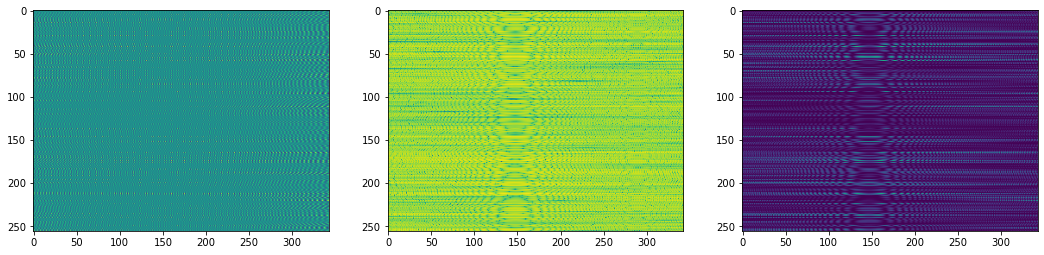

In [21]:
fig, axs = plt.subplots(1,3,figsize=(18, 6))
axs[0].imshow(spec_like[0].detach().numpy())
axs[1].imshow(np.log10(np.abs(spec_like[0].detach().numpy())+1e-6))
axs[2].imshow(np.log10(spec_like[0].detach().numpy()**2+1))

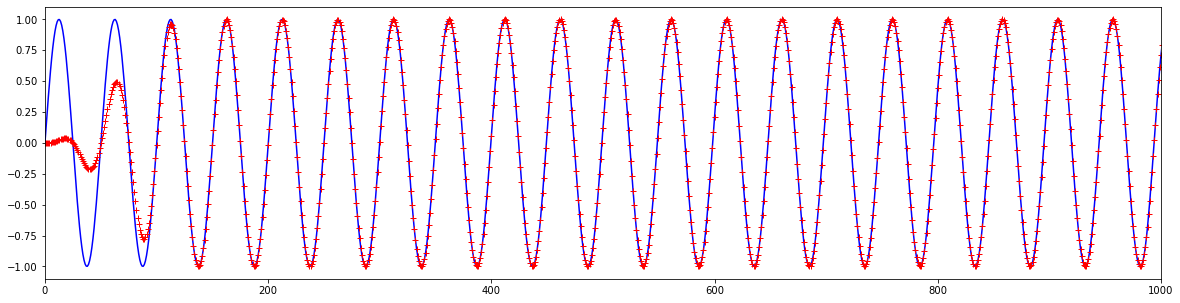

In [22]:
from asteroid.filterbanks import STFTFB
from asteroid.filterbanks.transforms import take_mag

dft_filters = STFTFB(n_filters=512, kernel_size=256, stride=128)
stft = Encoder(dft_filters)
idft_filters = STFTFB(n_filters=512, kernel_size=256, stride=128)
istft = Decoder(idft_filters)

spec = stft(waveform)
out_waveform = istft(spec)

fig, axes = plt.subplots(figsize=(20, 5))
axes.plot(waveform.squeeze().data.numpy(), 'b')
axes.plot(out_waveform.squeeze().data.numpy(), 'r+')
plt.xlim([0, 1000])
plt.show()

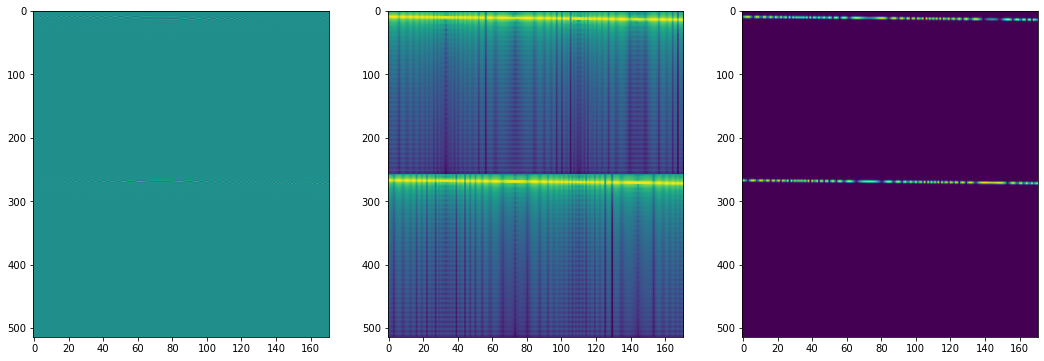

In [23]:
fig, axs = plt.subplots(1,3,figsize=(18, 6))
axs[0].imshow(spec[0].detach().numpy(), aspect='auto')
axs[1].imshow(np.log10(np.abs(spec[0].detach().numpy())+1e-6), aspect='auto')
axs[2].imshow(np.log10(spec[0].detach().numpy()**2+1), aspect='auto')

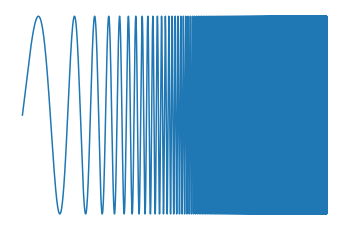

In [24]:
chirp = torch.Tensor(librosa.chirp(1, 640, sr=22050, duration=4).reshape(1,1,-1))
plt.plot(np.squeeze(chirp.numpy()))
plt.axis('off')
plt.show()
Audio(np.squeeze(chirp.numpy()), rate=22050)

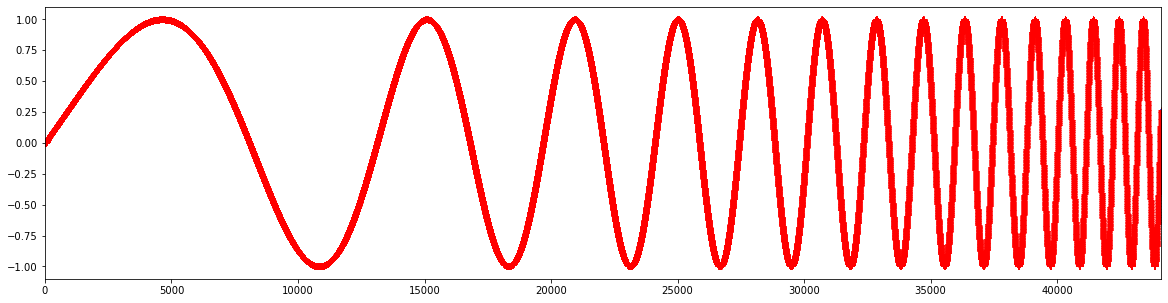

In [25]:
dft_filters = STFTFB(n_filters=512, kernel_size=256, stride=128)
stft = Encoder(dft_filters)
idft_filters = STFTFB(n_filters=512, kernel_size=256, stride=128)
istft = Decoder(idft_filters)

spec = stft(chirp)
out_waveform = istft(spec)

fig, axes = plt.subplots(figsize=(20, 5))
axes.plot(chirp.squeeze().data.numpy(), 'b')
axes.plot(out_waveform.squeeze().data.numpy(), 'r+')
plt.xlim([0, 22050*2])
plt.show()

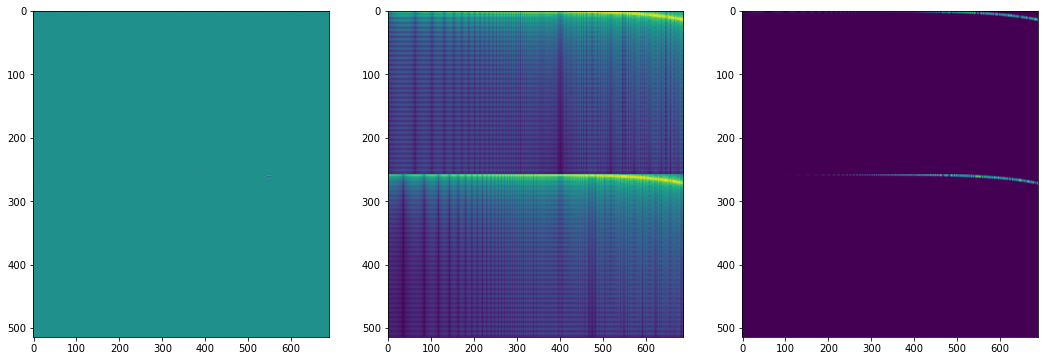

In [26]:
fig, axs = plt.subplots(1,3,figsize=(18, 6))
axs[0].imshow(spec[0].detach().numpy(), aspect='auto')
axs[1].imshow(np.log10(np.abs(spec[0].detach().numpy())+1e-6), aspect='auto')
axs[2].imshow(np.log10(spec[0].detach().numpy()**2+1), aspect='auto')

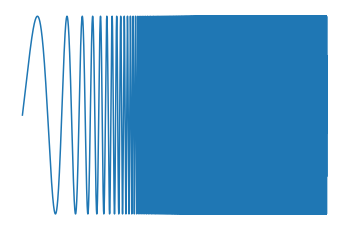

In [27]:
chirp = torch.Tensor(librosa.chirp(1, 11025, sr=22050, duration=4).reshape(1,1,-1))
plt.plot(np.squeeze(chirp.numpy()))
plt.axis('off')
plt.show()
Audio(np.squeeze(chirp.numpy()), rate=22050)

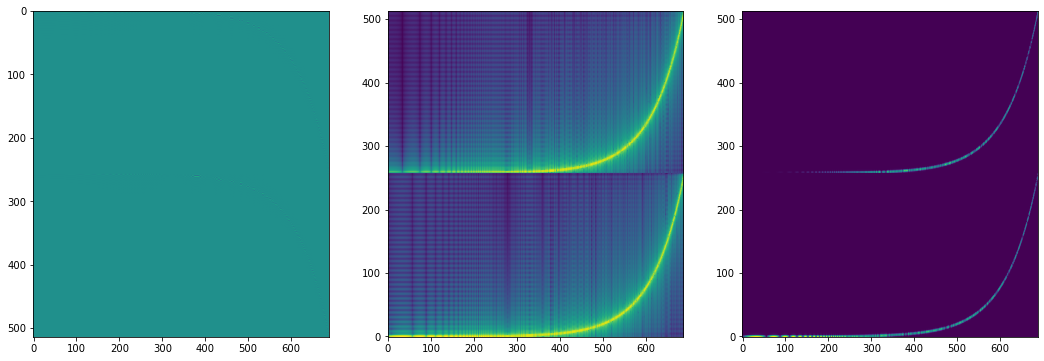

In [28]:
dft_filters = STFTFB(n_filters=512, kernel_size=256, stride=128)
stft = Encoder(dft_filters)
idft_filters = STFTFB(n_filters=512, kernel_size=256, stride=128)
istft = Decoder(idft_filters)

spec = stft(chirp)
out_waveform = istft(spec)

fig, axs = plt.subplots(1,3,figsize=(18, 6))
axs[0].imshow(spec[0].detach().numpy(), aspect='auto')
axs[1].imshow(np.log10(np.abs(spec[0].detach().numpy())+1e-6), aspect='auto')
axs[1].invert_yaxis()
axs[2].imshow(np.log10(spec[0].detach().numpy()**2+1), aspect='auto')
axs[2].invert_yaxis()

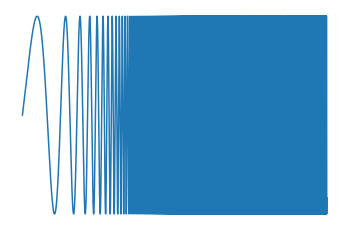

In [29]:
chirp = torch.Tensor(librosa.chirp(1, 22050, sr=22050, duration=4).reshape(1,1,-1))
plt.plot(np.squeeze(chirp.numpy()))
plt.axis('off')
plt.show()
Audio(np.squeeze(chirp.numpy()), rate=22050)

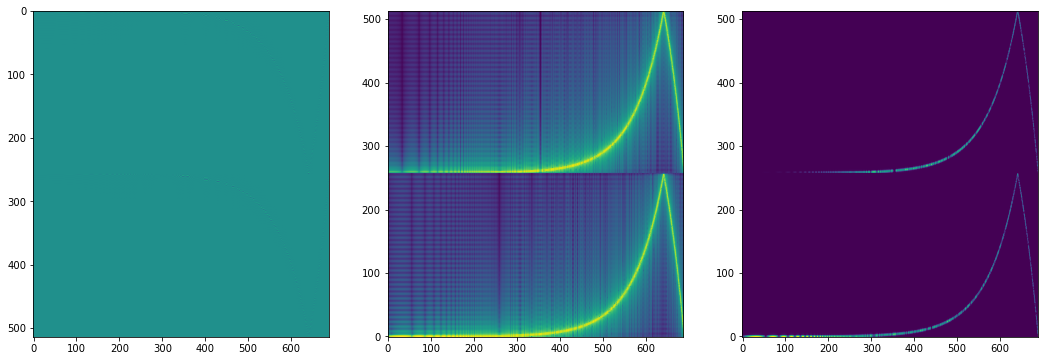

In [30]:
dft_filters = STFTFB(n_filters=512, kernel_size=256, stride=128)
stft = Encoder(dft_filters)
idft_filters = STFTFB(n_filters=512, kernel_size=256, stride=128)
istft = Decoder(idft_filters)

spec = stft(chirp)
out_waveform = istft(spec)

fig, axs = plt.subplots(1,3,figsize=(18, 6))
axs[0].imshow(spec[0].detach().numpy(), aspect='auto')
axs[1].imshow(np.log10(np.abs(spec[0].detach().numpy())+1e-6), aspect='auto')
axs[1].invert_yaxis()
axs[2].imshow(np.log10(spec[0].detach().numpy()**2+1), aspect='auto')
axs[2].invert_yaxis()

In [31]:
from asteroid.filterbanks import make_enc_dec

enc, dec = make_enc_dec('free', n_filters=500, kernel_size=80)
stft, istft = make_enc_dec('stft', n_filters=512, kernel_size=256, stride=128)
analytic_enc, pinv_dec = make_enc_dec('analytic_free', who_is_pinv='dec', n_filters=500, kernel_size=16, stride=8)

# Asteroid Notebooks: 03 PITLossWrapper

In [32]:
import torch
from itertools import permutations
import numpy as np
import matplotlib.pyplot as plt
from asteroid.losses import PITLossWrapper
from asteroid.losses import pairwise_mse, singlesrc_mse, multisrc_mse

In [33]:
batch_size, n_sources, feat_dim = 1, 4, 50
sources = torch.randn(batch_size, n_sources, feat_dim)
random_permutation = torch.randperm(n_sources)
estimate_sources = sources[:, random_permutation] + torch.randn(batch_size, n_sources, feat_dim)

In [34]:
sources.shape, random_permutation, estimate_sources.shape

(torch.Size([1, 4, 50]), tensor([2, 3, 1, 0]), torch.Size([1, 4, 50]))

In [35]:
perms = list(permutations(range(n_sources)))
all_losses = torch.stack([multisrc_mse(estimate_sources, sources[:, p]) for p in perms])
best_loss_idx = torch.argmin(all_losses)
print("Best permutation : {}. 0riginal permutation : {}".format(perms[best_loss_idx], random_permutation))

loss_func = PITLossWrapper(multisrc_mse, pit_from='perm_avg')
best_loss = loss_func(estimate_sources, sources)

Best permutation : (2, 3, 1, 0). 0riginal permutation : tensor([2, 3, 1, 0])


In [36]:
len(perms), all_losses.shape, best_loss_idx, all_losses[best_loss_idx], best_loss

(24, torch.Size([24, 1]), tensor(17), tensor([1.2702]), tensor(1.2702))

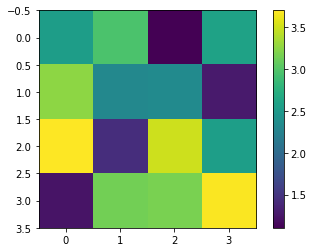

In [37]:
def mse(est_target, target):
    """ Batch MSE between a source and its estimate"""
    loss = (target - est_target)**2
    return loss.mean(-1)

pairwise_losses = torch.zeros(batch_size, n_sources, n_sources)
for i in range(n_sources):
    for j in range(n_sources):
        pairwise_losses[:, i, j] = mse(estimate_sources[:, i], sources[:, j])
ax = plt.imshow(pairwise_losses[0].data.numpy())
plt.colorbar()

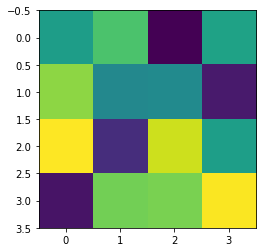

In [38]:

# We can also compute the pairwise losses directly using dimension broadcasting
def pairwise_mse(est_targets, targets):
    """ Batch pairwise MSE. """
    targets = targets.unsqueeze(1)
    est_targets = est_targets.unsqueeze(2)
    pw_loss = (targets - est_targets)**2
    mean_over = list(range(3, pw_loss.ndim))
    return pw_loss.mean(dim=mean_over)

direct_pairwise_losses = pairwise_mse(estimate_sources, sources)
torch.testing.assert_allclose(pairwise_losses, direct_pairwise_losses)
ax = plt.imshow(direct_pairwise_losses[0].data.numpy())

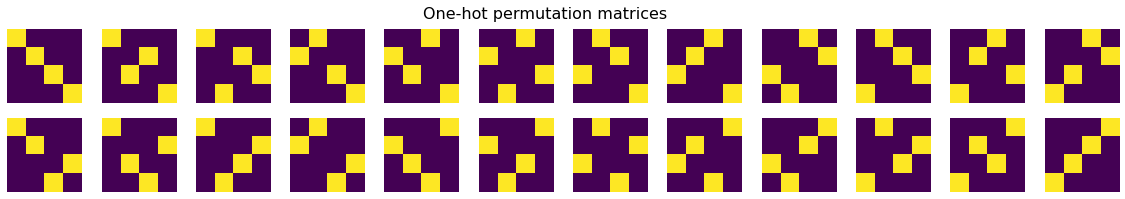

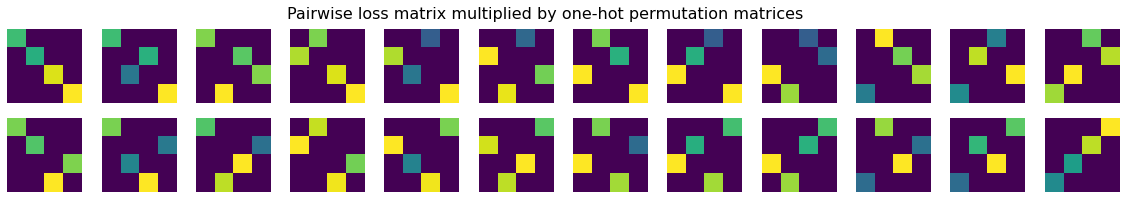

In [39]:
eye = torch.eye(n_sources)
perms_one_hot = torch.stack([eye[:, perm] for perm in perms], dim=0)
fig, axs = plt.subplots(2, len(perms)//2, figsize=(20, 3))
fig.suptitle('One-hot permutation matrices', fontsize=16)
for i in range(len(perms)):
    col, line = divmod(i, 2)
    axs[line, col].imshow((perms_one_hot[i]).data.numpy())
    axs[line, col].set_axis_off()

fig, axs = plt.subplots(2, len(perms)//2, figsize=(20, 3))
fig.suptitle('Pairwise loss matrix multiplied by one-hot permutation matrices', fontsize=16)
for i in range(len(perms)):
    col, line = divmod(i, 2)
    axs[line, col].imshow((perms_one_hot[i] * pairwise_losses[0]).data.numpy())
    axs[line, col].set_axis_off()

In [40]:
print("For MSE")
print("1. Naive approach ")
loss_func = PITLossWrapper(multisrc_mse, pit_from='perm_avg')
%timeit best_loss = loss_func(sources, estimate_sources)
print("2. More efficient approaches (b)")
loss_func = PITLossWrapper(singlesrc_mse, pit_from='pw_pt')
%timeit best_loss = loss_func(sources, estimate_sources)
print("2. More efficient approaches (b)")
loss_func = PITLossWrapper(pairwise_mse, pit_from='pw_mtx')
%timeit best_loss = loss_func(sources, estimate_sources)

For MSE
1. Naive approach 
1.81 ms ± 18.4 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
2. More efficient approaches (b)
1.32 ms ± 11.3 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
2. More efficient approaches (b)
270 µs ± 3.43 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [41]:
from asteroid.losses import pairwise_neg_sisdr, singlesrc_neg_sisdr, multisrc_neg_sisdr
print("For SI-SDR")
print("1. Naive approach ")
loss_func = PITLossWrapper(multisrc_neg_sisdr, pit_from='perm_avg')
%timeit best_loss = loss_func(sources, estimate_sources)
print("2. More efficient approaches (b)")
loss_func = PITLossWrapper(singlesrc_neg_sisdr, pit_from='pw_pt')
%timeit best_loss = loss_func(sources, estimate_sources)
print("2. More efficient approaches (b)")
loss_func = PITLossWrapper(pairwise_neg_sisdr, pit_from='pw_mtx')
%timeit best_loss = loss_func(sources, estimate_sources)

For SI-SDR
1. Naive approach 
5.72 ms ± 34.9 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
2. More efficient approaches (b)
3.59 ms ± 39.2 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
2. More efficient approaches (b)
476 µs ± 5.92 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


# Asteroid Notebooks: 04 Process Large Audio Files

In [42]:
import torch

from asteroid import ConvTasNet
from asteroid.dsp.overlap_add import LambdaOverlapAdd


nnet = ConvTasNet(n_src=2)
continuous_nnet = LambdaOverlapAdd(
        nnet=nnet,  # function to apply to each segment.
        n_src=2,  # number of sources in the output of nnet
        window_size=64000,  # Size of segmenting window
        hop_size=None,  # segmentation hop size
        window="hanning",  # Type of the window (see scipy.signal.get_window
        reorder_chunks=True,  # Whether to reorder each consecutive segment.
        enable_grad=False,  # Set gradient calculation on of off (see torch.set_grad_enabled)
)

# Instantiate long wav (1min) that would OOM
wav = torch.randn(1, 1, 500000)
out_wavs = continuous_nnet.forward(wav)
# Or on GPU
continuous_nnet.cuda()
wav = wav.cuda()
out_wavs_gpu = continuous_nnet.forward(wav)

# Community Notebook: Numpy vs Asteroid STFT

In [43]:
!wget http://www.fit.vutbr.cz/~motlicek/sympatex/f2bjrop1.0.wav -O example.wav
!wget https://www2.cs.uic.edu/~i101/SoundFiles/StarWars3.wav -O example2.wav

--2020-09-14 18:38:39--  http://www.fit.vutbr.cz/~motlicek/sympatex/f2bjrop1.0.wav
Resolving www.fit.vutbr.cz (www.fit.vutbr.cz)... 147.229.9.23, 2001:67c:1220:809::93e5:917
Connecting to www.fit.vutbr.cz (www.fit.vutbr.cz)|147.229.9.23|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 356524 (348K) [audio/x-wav]
Saving to: ‘example.wav’

example.wav         100%[===================>] 348.17K   385KB/s    in 0.9s    

2020-09-14 18:38:41 (385 KB/s) - ‘example.wav’ saved [356524/356524]

--2020-09-14 18:38:41--  https://www2.cs.uic.edu/~i101/SoundFiles/StarWars3.wav
Resolving www2.cs.uic.edu (www2.cs.uic.edu)... 131.193.32.16
Connecting to www2.cs.uic.edu (www2.cs.uic.edu)|131.193.32.16|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 132344 (129K) [audio/x-wav]
Saving to: ‘example2.wav’

example2.wav        100%[===================>] 129.24K  --.-KB/s    in 0.1s    

2020-09-14 18:38:42 (928 KB/s) - ‘example2.wav’ saved [132344/132344]



In [44]:
!pip install -e "git+https://github.com/fgnt/paderbox.git@master#egg=paderbox"
!pip install miniaudio

Obtaining paderbox from git+https://github.com/fgnt/paderbox.git@master#egg=paderbox
  Updating ./src/paderbox clone (to revision master)
  Attempting uninstall: paderbox
    Found existing installation: paderbox 0.0.3
    Uninstalling paderbox-0.0.3:
      Successfully uninstalled paderbox-0.0.3
  Running setup.py develop for paderbox


In [46]:
import IPython.display as ipd
import miniaudio
import numpy as np
import torch 
from datetime import datetime 
import asteroid

In [47]:
def audio_player(*args, **kwargs):
    return ipd.display(ipd.Audio(*args, **kwargs))

def audio_player_t(t, rate=16000):
    return audio_player(t.squeeze(0).detach().numpy(), rate=rate)


def load_audio(full_path, sample_rate=16000):
    m_audio = miniaudio.decode_file(
        full_path,
        nchannels=1,
        sample_rate=sample_rate,
        output_format=miniaudio.SampleFormat.FLOAT32,
        dither=miniaudio.DitherMode.NONE,
    )
    audio = np.array(m_audio.samples, dtype="float32")
    return audio

def load_audio_t(path, sample_rate=16000):
    y = load_audio(path, sample_rate=sample_rate)
    return torch.tensor(y, dtype=torch.float32).unsqueeze(0)

def t_to_np(y):
    return y.cpu().detach().numpy()

def rms(x, y):
    return np.sqrt(np.mean((x - y)**2))

def rms_t(x, y):
    return torch.mean((x - y) ** 2) ** 0.5

In [48]:
def numpy_stft(x, window_size=512, hop_size=256, n_fft=None):
    if n_fft is None:
        n_fft = window_size 

    # Match window asteroid uses https://github.com/mpariente/asteroid/blob/master/asteroid/filterbanks/stft_fb.py#L29
    w = np.hanning(window_size + 1)[:-1] ** 0.5

    total_length = x.shape[0]
    # Split frames into strided overlapping chunks of length window_size 
    frames_strided = [w * x[i: i + window_size] for i in range(0, total_length - window_size, hop_size)]

    X = np.fft.rfft(frames_strided, n_fft)
    X /= 0.5 * np.sqrt(kernel_size * n_fft / hop_size)
    return X

In [49]:
from asteroid.filterbanks import Encoder, Decoder, STFTFB
from asteroid.filterbanks.transforms import take_cat, take_mag, from_numpy 

kernel_size = 512
stride = kernel_size // 2
n_filters = 512

# Asteroid  
x_t = load_audio_t("example.wav")
stft_fb = STFTFB(n_filters=n_filters, kernel_size=kernel_size, stride=stride)
encoder = Encoder(stft_fb)
asteroid_tf_rep = encoder(x_t.unsqueeze(0)) # torch.tensor 
asteroid_mag_spec = t_to_np(take_mag(asteroid_tf_rep).transpose(1, 2).squeeze(0))

# Numpy 
x = load_audio("example.wav")
numpy_tf_rep = numpy_stft(x, window_size=kernel_size, hop_size=stride, n_fft=n_filters) # numpy.array

numpy_mag_spec = np.abs(numpy_tf_rep)

mag_diff = rms(numpy_mag_spec, asteroid_mag_spec)
print("rms between numpy and asteroid magnitude spectrums: {}".format(mag_diff))
print("numpy vs asteroid")
print("std", numpy_mag_spec.std(), asteroid_mag_spec.std())
print("min", numpy_mag_spec.min(), asteroid_mag_spec.min())
print("max", numpy_mag_spec.max(), asteroid_mag_spec.max())
print("mean", numpy_mag_spec.mean(), asteroid_mag_spec.mean())

rms between numpy and asteroid magnitude spectrums: 0.00036860521814317587
numpy vs asteroid
std 0.08835199869018556 0.08835242
min 6.200615675858862e-08 0.00010000001
max 3.346635902862928 3.346636
mean 0.024290456754280782 0.024272803


/home/peterbermant/Workspace/Cocktail-Party-Problem/Human-Speech-and-Music/src/paderbox/paderbox/visualization/plot.py:380: UserWarning: The array passed to spectrogram contained negative values. This leads to a wrong visualization and especially colorbar!
  warn('The array passed to spectrogram contained negative values. This '


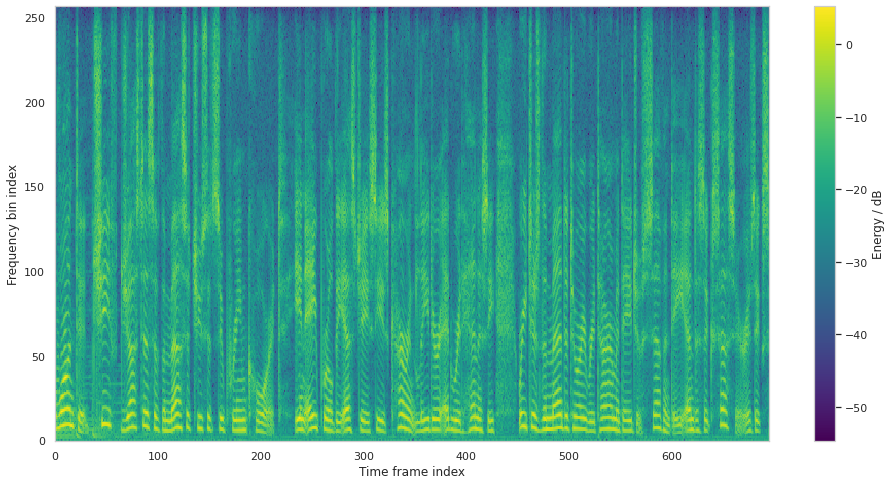

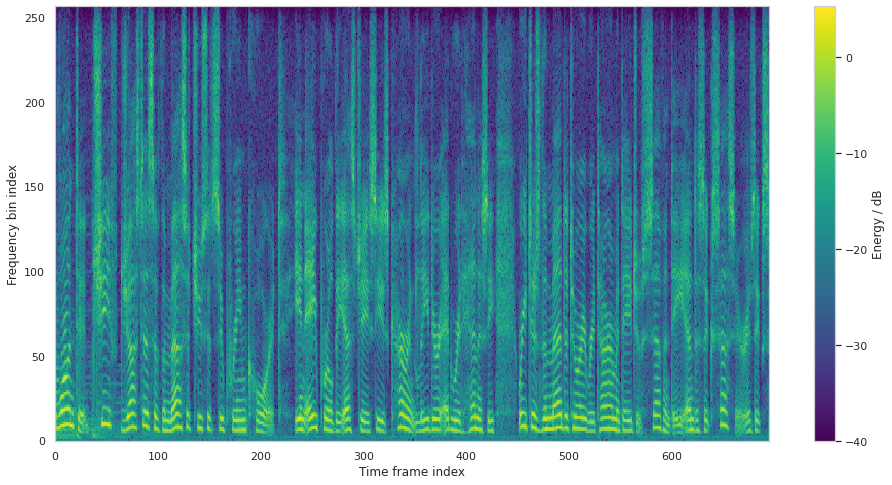

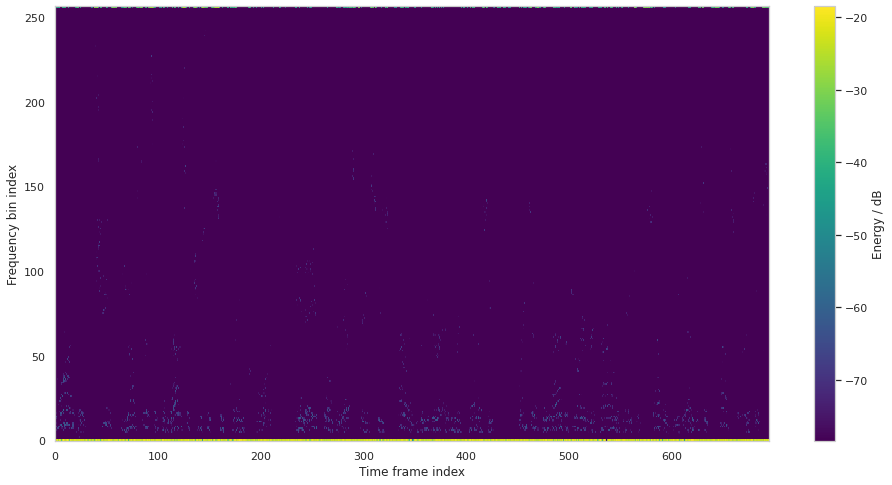

In [50]:
from paderbox.visualization import plot 
from paderbox.notebook import play, facet_grid, axes_context, plt 

with axes_context(columns=1, figure_size=(16., 8.)) as ax:
    plot.spectrogram(numpy_mag_spec, sample_rate=16000, ax=ax[0])
    plot.spectrogram(asteroid_mag_spec, sample_rate=16000, ax=ax[1])
    plot.spectrogram(numpy_mag_spec - asteroid_mag_spec, sample_rate=16000, ax=ax[2])